# Wellness Summary 

This is a follow up to the wellness factor analysis. In that notebook, we found that wellness can be summarized in terms of the `MonitoringScore`, `Pain`, `Illness`, and `Nutrition`.

This notebook will apply the same processing with the goal of finding a summary measure for wellness. In doing so, I want to try and improve the imputing of nutrition but samping from the given player's nutrition distribution instead of the overall distribution.

## Load Data

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr, ttest_ind
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
np.random.seed(5151)
wellness_df = pd.read_csv('./raw_data/wellness.csv')
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


## Inpute Nutrition Values

In order for this to work, I need to make sure the missing nutrition values are not all stemming from a small number of players not providing nutrition information for most days. In this case, the distribution of their nutrition responses will be quite inaccurate and my imputed values with have high bias.

In [3]:
missing_nutrition_df = wellness_df[wellness_df['Nutrition'].isnull()]
missing_nutrition_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
1,2018-07-21,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
13,2018-07-20,2,4,4,5,4,22:00:00,07:00:00,9.00,3,20,Yes,No,Yes,NaN,NaN,Yes,1.017,0%
14,2018-07-20,3,4,4,6,4,22:30:00,06:30:00,8.00,4,22,No,No,No,NaN,NaN,Yes,1.016,100%
25,2018-07-19,2,4,4,5,4,22:15:00,08:00:00,9.75,5,22,Yes,No,Yes,NaN,NaN,Yes,1.023,0%


In [4]:
missing_nutrition_df.shape


(837, 19)

In [5]:
missing_nutrition_df['PlayerID'].value_counts()


2     280
8     182
14     73
6      72
17     71
1      56
4      51
5      24
3      20
15      5
13      1
10      1
7       1
Name: PlayerID, dtype: int64

Unfortunatly, I appears the majority of missing nutrition values are coming from players 2 and 8. Let's take a look at their nutrition distributions.

### Nutrition For Player 2

In [6]:
wellness_df[wellness_df['PlayerID'] == 2]['Nutrition'].value_counts(normalize=True)


Excellent    0.593220
Okay         0.389831
Poor         0.016949
Name: Nutrition, dtype: float64

#### Compared to average distribution

In [7]:
wellness_df['Nutrition'].value_counts(normalize=True)

Excellent    0.649976
Okay         0.334931
Poor         0.015093
Name: Nutrition, dtype: float64

We see that the distribution for player 2 is the same as the distribution overall so it is unlikely that the samples that we have from this player have high bias.

### Nutrition For Player 8

In [8]:
wellness_df[wellness_df['PlayerID'] == 8]['Nutrition'].value_counts(normalize=True)


Excellent    0.496
Okay         0.392
Poor         0.112
Name: Nutrition, dtype: float64

The distribution for this player does differ from the average distribution, but, we have more samples of this player's nutrition so we can inpute their values using their own nutrition distribution without adding too much bias into our dataset.

### Imputing Nutrition Using Player-Specific Distribution

In [9]:
def impute_nutrition(row):
    if (isinstance(row['Nutrition'], float) and (np.isnan(row['Nutrition']))):
        normalized_nutrition_value_counts = wellness_df[wellness_df['PlayerID'] == row['PlayerID']]['Nutrition'].value_counts(normalize=True)
        
        return np.random.choice(normalized_nutrition_value_counts.index, size=1, p=normalized_nutrition_value_counts.values)[0]
    else:
        return row['Nutrition']
    
wellness_df['Nutrition'] = wellness_df.apply(impute_nutrition, axis=1)

wellness_df.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,Excellent,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,Excellent,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


Now we just need to make sure there are not missing nutrition values left.

In [10]:
wellness_df[wellness_df['Nutrition'].isnull()].shape

(0, 19)

## Extract Features

Based on the previous wellness factor analysis

In [11]:
processed_wellness_df = wellness_df.copy()[['Date', 'PlayerID', 'MonitoringScore', 'TrainingReadiness', 'Pain', 'Illness', 'Nutrition']]
processed_wellness_df.head()


,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition
0,2018-07-21,1,13,0%,No,No,Excellent
1,2018-07-21,2,19,0%,Yes,No,Excellent
2,2018-07-21,3,19,100%,No,No,Excellent
3,2018-07-21,4,15,95%,No,No,Excellent
4,2018-07-21,5,20,100%,No,No,Okay


### Map To Numbers

#### Pain

In [12]:
processed_wellness_df['Pain'] = processed_wellness_df['Pain'].map(dict(Yes=0, No=1))
processed_wellness_df.head()


,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition
0,2018-07-21,1,13,0%,1,No,Excellent
1,2018-07-21,2,19,0%,0,No,Excellent
2,2018-07-21,3,19,100%,1,No,Excellent
3,2018-07-21,4,15,95%,1,No,Excellent
4,2018-07-21,5,20,100%,1,No,Okay


#### Illness

In [13]:
processed_wellness_df['Illness'] = processed_wellness_df['Illness'].map({'Yes': 0, 'Slightly Off': 2, 'No': 3})
processed_wellness_df.head()


,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition
0,2018-07-21,1,13,0%,1,3,Excellent
1,2018-07-21,2,19,0%,0,3,Excellent
2,2018-07-21,3,19,100%,1,3,Excellent
3,2018-07-21,4,15,95%,1,3,Excellent
4,2018-07-21,5,20,100%,1,3,Okay


#### Nutrition

In [14]:
processed_wellness_df['Nutrition'] = processed_wellness_df['Nutrition'].map({'Excellent': 3, 'Okay': 2, 'Poor': 1})
processed_wellness_df.head()


,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition
0,2018-07-21,1,13,0%,1,3,3
1,2018-07-21,2,19,0%,0,3,3
2,2018-07-21,3,19,100%,1,3,3
3,2018-07-21,4,15,95%,1,3,3
4,2018-07-21,5,20,100%,1,3,2


In [15]:
processed_wellness_df['Nutrition'].value_counts()

3    3227
2    1705
1      79
Name: Nutrition, dtype: int64

#### Training Readiness

In [16]:
processed_wellness_df['TrainingReadiness'] = processed_wellness_df.apply(lambda row: int(row['TrainingReadiness'][0:-1]), axis=1)
processed_wellness_df.head()


,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition
0,2018-07-21,1,13,0,1,3,3
1,2018-07-21,2,19,0,0,3,3
2,2018-07-21,3,19,100,1,3,3
3,2018-07-21,4,15,95,1,3,3
4,2018-07-21,5,20,100,1,3,2


### Standardize

We need to standardize the player features so they are all on the same scale. This will make sure we can add all the data together to get one summary value for the player's wellness.

In [17]:
scaled_wellness_values = StandardScaler().fit_transform(processed_wellness_df[['MonitoringScore', 'Pain', 'Illness', 'Nutrition', 'TrainingReadiness']])
processed_wellness_df['StandardizedMonitoringScore'] = scaled_wellness_values[:, 0]
processed_wellness_df['StandardizedPain'] = scaled_wellness_values[:, 1]
processed_wellness_df['StandardizedIllness'] = scaled_wellness_values[:, 2]
processed_wellness_df['StandardizedNutrition'] = scaled_wellness_values[:, 3]
processed_wellness_df['StandardizedTrainingReadiness'] = scaled_wellness_values[:, 4]

processed_wellness_df.head()


,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedTrainingReadiness
0,2018-07-21,1,13,0,1,3,3,-1.450204,0.364611,0.301008,0.722090,-1.826823
1,2018-07-21,2,19,0,0,3,3,0.170622,-2.742646,0.301008,0.722090,-1.826823
2,2018-07-21,3,19,100,1,3,3,0.170622,0.364611,0.301008,0.722090,0.795746
3,2018-07-21,4,15,95,1,3,3,-0.909929,0.364611,0.301008,0.722090,0.664618
4,2018-07-21,5,20,100,1,3,2,0.440759,0.364611,0.301008,-1.220149,0.795746


### Normalize Mointoring Score and Nutrition

### Summarize Into Single Wellness Measure

In [18]:
processed_wellness_df['wellness'] = processed_wellness_df['StandardizedMonitoringScore'] + processed_wellness_df['StandardizedPain'] + processed_wellness_df['StandardizedIllness'] + processed_wellness_df['StandardizedNutrition'] + processed_wellness_df['StandardizedTrainingReadiness']
processed_wellness_df.head()


,Date,PlayerID,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,StandardizedMonitoringScore,StandardizedPain,StandardizedIllness,StandardizedNutrition,StandardizedTrainingReadiness,wellness
0,2018-07-21,1,13,0,1,3,3,-1.450204,0.364611,0.301008,0.722090,-1.826823,-1.889318
1,2018-07-21,2,19,0,0,3,3,0.170622,-2.742646,0.301008,0.722090,-1.826823,-3.375750
2,2018-07-21,3,19,100,1,3,3,0.170622,0.364611,0.301008,0.722090,0.795746,2.354077
3,2018-07-21,4,15,95,1,3,3,-0.909929,0.364611,0.301008,0.722090,0.664618,1.142398
4,2018-07-21,5,20,100,1,3,2,0.440759,0.364611,0.301008,-1.220149,0.795746,0.681976


#### Save to file

In [19]:
processed_wellness_df.to_csv('./processed_data/processed_wellness.csv')

### Average For Each Player Over All Dates

In [20]:
average_wellness_df = processed_wellness_df[['Date', 'PlayerID', 'wellness']].copy()
average_wellness_df = average_wellness_df.drop(columns=['Date'])
average_wellness_df = average_wellness_df.groupby('PlayerID', as_index=False).mean()
average_wellness_df


,PlayerID,wellness
0,1,-0.920842
1,2,-1.413553
2,3,1.922391
3,4,0.973343
4,5,-1.775303
5,6,1.022469
6,7,1.172742
7,8,-2.028500
8,9,2.010883
9,10,-3.302844


<BarContainer object of 17 artists>

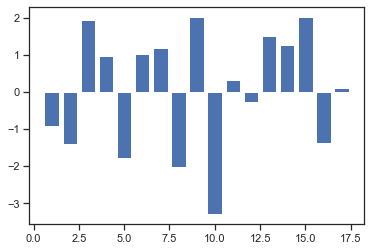

In [21]:
plt.bar(average_wellness_df['PlayerID'], average_wellness_df['wellness'])

We see that the player with the highest wellness is player 10 and the player with the lowest wellness is player 17 but players 16 and 12 also have low wellness.